# Sentiment analysis and classification from Amazon Fashion Rating Reviews
- Dataset : [Julian McAuley (UCSD)](https://jmcauley.ucsd.edu/data/amazon/)
- Size    : 883,636 reviews

In [1]:
# import basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
reviews_df = pd.read_json('./data/AMAZON_FASHION.json', lines=True)
reviews_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


## EDA and Data Preparations

In [3]:
reviews_df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')

In [4]:
reviews_df.drop(columns=['verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'vote', 'style', 'image'], inplace=True)
reviews_df.head()

,overall,reviewText,summary
0,5,Exactly what I needed.,perfect replacements!!
1,2,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ..."
2,4,Love these... I am going to order another pack...,My New 'Friends' !!
3,2,too tiny an opening,Two Stars
4,3,Okay,Three Stars


In [5]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     883636 non-null  int64 
 1   reviewText  882403 non-null  object
 2   summary     883103 non-null  object
dtypes: int64(1), object(2)
memory usage: 20.2+ MB


In [6]:
reviews_df.dropna(inplace=True)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881900 entries, 0 to 883635
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     881900 non-null  int64 
 1   reviewText  881900 non-null  object
 2   summary     881900 non-null  object
dtypes: int64(1), object(2)
memory usage: 26.9+ MB


In [7]:
# create sentiment columns (label)
conditions = [
    (reviews_df['overall'] <= 3), # negative sentiment for reviews rating 1 - 3 out of 5
    (reviews_df['overall'] > 3) # positive sentiment for review rating 4 and 5 out of 5
    ]

sentiment = ['Negative', 'Positive']

sentiment_int = [0, 1]

reviews_df['sentiment'] = np.select(conditions, sentiment)
reviews_df['sentiment_int'] = np.select(conditions, sentiment_int)

reviews_df[['sentiment', 'sentiment_int']].head()

,sentiment,sentiment_int
0,Positive,1
1,Negative,0
2,Positive,1
3,Negative,0
4,Negative,0


In [8]:
reviews_df[reviews_df['sentiment_int'] == 0][['reviewText', 'summary']]

,reviewText,summary
1,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ..."
3,too tiny an opening,Two Stars
4,Okay,Three Stars
7,mother - in - law wanted it as a present for h...,bought as a present
8,"Item is of good quality. Looks great, too. But...",Buxton heiress collection
...,...,...
883614,Really cute dress. I bought a small and medium...,Really cute dress. I bought a small and medium...
883615,Ordered an XL\nFits like a M\nThe fabric is ad...,Runs very small
883621,too sheer,Two Stars
883633,Too big in the chest area!,Three Stars


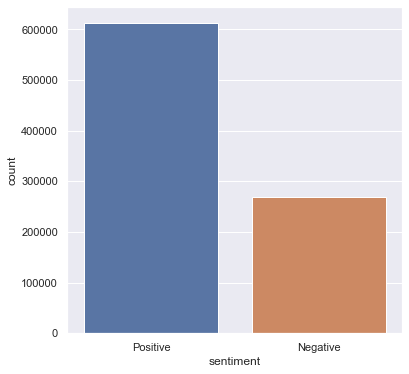

In [9]:
sns.set()
plt.figure(figsize=(6,6))
sns.countplot(reviews_df['sentiment'])

## Preprocessing

In [10]:
# regularize and cleaning review text 
reviews_df['text_cleaned'] = reviews_df['reviewText'].str.replace('[^a-zA-Z]',' ')
reviews_df['text_cleaned'] = reviews_df['text_cleaned'].str.lower()

reviews_df['summary_cleaned'] = reviews_df['summary'].str.replace('[^a-zA-Z]',' ')
reviews_df['summary_cleaned'] = reviews_df['summary_cleaned'].str.lower()

reviews_df[['text_cleaned', 'summary_cleaned']].head()

,text_cleaned,summary_cleaned
0,exactly what i needed,perfect replacements
1,i agree with the other review the opening is ...,i agree with the other review the opening is
2,love these i am going to order another pack...,my new friends
3,too tiny an opening,two stars
4,okay,three stars


In [11]:
X = reviews_df['summary_cleaned']
y = reviews_df['sentiment']

In [12]:
# splitting data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify=y, random_state=42)

print(f'Shape of X_train : {X_train.shape}')
print(f'Shape of X_test : {X_test.shape}')
print(f'Shape of y_train : {y_train.shape}')
print(f'Shape of y_test : {y_test.shape}')

Shape of X_train : (590873,)
Shape of X_test : (291027,)
Shape of y_train : (590873,)
Shape of y_test : (291027,)


In [13]:
y_train.value_counts()

Positive    410955
Negative    179918
Name: sentiment, dtype: int64

In [14]:
y_test.value_counts()

Positive    202411
Negative     88616
Name: sentiment, dtype: int64

In [15]:
X_train.head(2)

571494    so i am so pleased with this hat
438780                          five stars
Name: summary_cleaned, dtype: object

## Modeling

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# create pipeline model object
tvec = TfidfVectorizer(stop_words='english')
clf = MultinomialNB()

model = Pipeline([('vectorizer', tvec), ('classifier', clf)])
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('classifier', MultinomialNB())])

## Predicting and score

In [17]:
from sklearn.metrics import confusion_matrix

prediction = model.predict(X_test)

confusion_matrix(prediction, y_test)


array([[ 48022,   9119],
       [ 40594, 193292]], dtype=int64)

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc = accuracy_score(prediction, y_test)
precision = precision_score(prediction, y_test, average='weighted')
recall = recall_score(prediction, y_test, average = 'weighted')

print(f'Accuracy : {acc}')
print(f'Precision : {precision}')
print(f'Recall : {recall}')

Accuracy : 0.8291807976579493
Precision : 0.8738513522030771
Recall : 0.8291807976579493


## Saving model

In [29]:
import pickle

with open('./models/sentiment_classifier.pkl', 'wb') as f:
    pickle.dump(model, f)

# Trying some example

In [19]:
def sentiment_predict(text):
    cleaned_text = re.sub('[^a-zA-Z]',' ', text)
    cleaned_text = cleaned_text.lower()

    sentiment = model.predict([cleaned_text])

    print(sentiment)

In [25]:
sentiment_predict('So bad')

sentiment_predict('i love this')

sentiment_predict('jhebt143t')

sentiment_predict('i am so disappointed')

sentiment_predict('Lorem ipsum dolor sit amet,')

sentiment_predict('what is this product? i feel like in a heaven')

sentiment_predict('i think this is the best product ever, totally worth to buy. but i also think this is a very bad product')

sentiment_predict('i think this is the best product ever, totally worth to buy. but i also think this is a very bad product i hate it so much')

['Negative']
['Positive']
['Positive']
['Negative']
['Negative']
['Positive']
['Positive']
['Negative']
